In [ ]:
!pip install opendatasets

In [ ]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline
import opendatasets as od
from sklearn import metrics
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import plot_model

In [ ]:
#upload the data into colab
od.download("https://www.kaggle.com/datasets/itamargr/dfdc-faces-of-the-train-sample")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mustafaarahim
Your Kaggle Key: ··········


100%|██████████| 3.64G/3.64G [03:13<00:00, 20.2MB/s]


In [ ]:
ig = ImageDataGenerator(rescale=1./255.)
train_flow = ig.flow_from_directory(
   '/content/dfdc-faces-of-the-train-sample/train',
    target_size=(160, 160),
    batch_size=100,
    class_mode='categorical'

)

ig1 = ImageDataGenerator(rescale=1./255.)

valid_flow = ig1.flow_from_directory(
   '/content/dfdc-faces-of-the-train-sample/validation',
     target_size=(160, 160),
    batch_size=100,
    class_mode='categorical'

)

test_flow = ig.flow_from_directory(
   '/content/dfdc-faces-of-the-train-sample/validation',
     target_size=(160, 160),
    batch_size=100,
    shuffle = False,
    class_mode='categorical'
)

train_flow.class_indices

Found 93853 images belonging to 2 classes.
Found 30794 images belonging to 2 classes.
Found 30794 images belonging to 2 classes.


{'fake': 0, 'real': 1}

In [ ]:
def build_model():
    densenet = ResNet50V2(
                        weights='imagenet',
                        include_top=False,
                        input_shape=(160,160,3)
                        )
    model = Sequential([densenet,

                        layers.GlobalAveragePooling2D(),
                        layers.Dense(1024, activation = 'relu'),
                        layers.BatchNormalization(),
                         layers.Dense(256, activation = 'relu'),
                        layers.BatchNormalization(),


                        layers.Dense(2, activation='softmax')
                        ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                 )
    return model

In [ ]:
model=build_model()
model.summary()

94668760/94668760 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                         

In [ ]:
checkpoint = ModelCheckpoint(filepath='model.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=1,
                              verbose=1,
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [ ]:
history = model.fit(train_flow,
    epochs = 5,
    validation_data =valid_flow,
    callbacks=callbacks
)

Epoch 1/5
939/939 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9363
Epoch 1: val_loss improved from inf to 0.69554, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


939/939 [==============================] - 577s 564ms/step - loss: 0.1745 - accuracy: 0.9363 - val_loss: 0.6955 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 2/5
939/939 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9709
Epoch 2: val_loss improved from 0.69554 to 0.58384, saving model to model.h5
939/939 [==============================] - 534s 568ms/step - loss: 0.0735 - accuracy: 0.9709 - val_loss: 0.5838 - val_accuracy: 0.8152 - lr: 0.0010
Epoch 3/5
939/939 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9755
Epoch 3: val_loss did not improve from 0.58384

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
939/939 [==============================] - 518s 552ms/step - loss: 0.0610 - accuracy: 0.9755 - val_loss: 0.6569 - val_accuracy: 0.7797 - lr: 0.0010
Epoch 4/5
939/939 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9861
Epoch 4: val_loss improved from 0.58384 to 0.56535, saving model to m

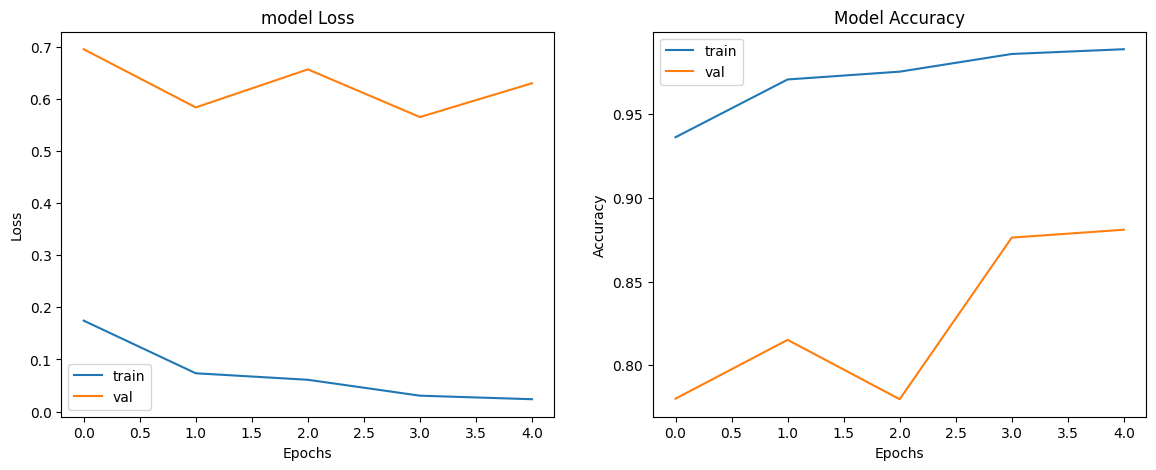

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])

plt.show()

In [ ]:
y_pred = model.predict(test_flow)
y_test = test_flow.classes

308/308 [==============================] - 58s 186ms/step


In [ ]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [ ]:
confusion_matrix=confusion_matrix(y_test, y_pred_labels)
confusion_matrix

array([[22265,  2500],
       [ 1164,  4865]])

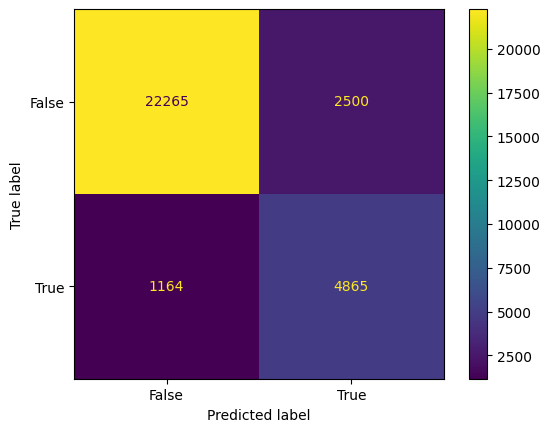

In [ ]:
Fake=False
Real=True
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [Fake, Real])
cm_display.plot()
plt.show()

In [ ]:
_, accu = model.evaluate(test_flow)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

308/308 [==============================] - 58s 187ms/step - loss: 0.6302 - accuracy: 0.8810
Final Test Acccuracy = 88.102


In [ ]:
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred_labels))
print("AP Score:", metrics.average_precision_score(y_test, y_pred_labels))
print()
print(metrics.classification_report(y_test, y_pred_labels))

ROC AUC Score: 0.852992118282062
AP Score: 0.5708246638010029

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     24765
           1       0.66      0.81      0.73      6029

    accuracy                           0.88     30794
   macro avg       0.81      0.85      0.83     30794
weighted avg       0.89      0.88      0.89     30794



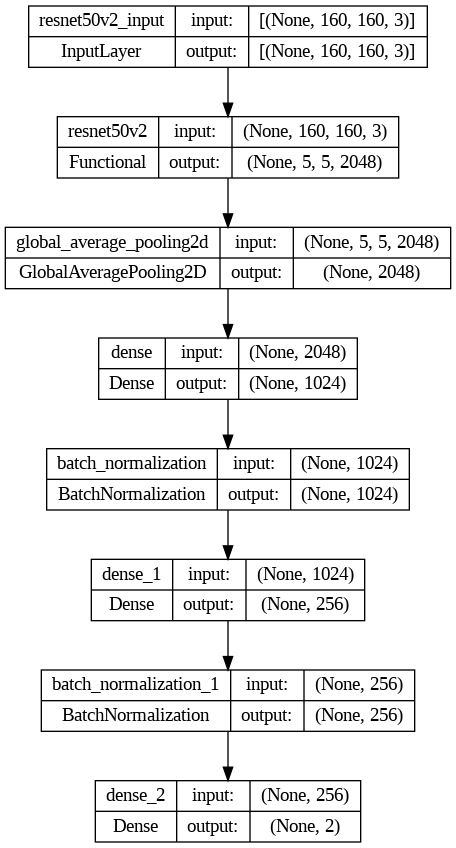

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)